In [32]:
!git clone https://github.com/Marneus981/ECE421.git

Cloning into 'ECE421'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 1), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [33]:
data_path = '/content/ECE421/notMNIST.npz'

In [180]:
%%shell
jupyter nbconvert --to html /content/ECE421A2_1004731347.ipynb

[NbConvertApp] Converting notebook /content/ECE421A2_1004731347.ipynb to html
[NbConvertApp] Writing 1630570 bytes to /content/ECE421A2_1004731347.html


# Neural Networks using Numpy

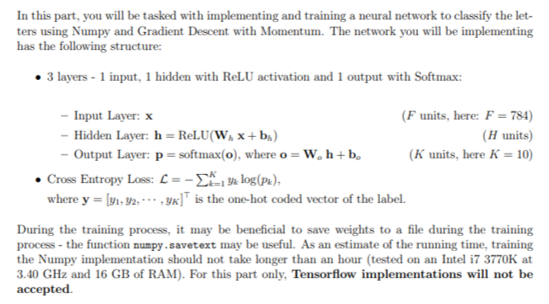

##Helper Functions

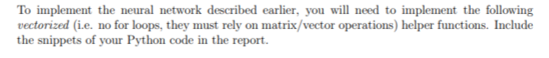

In [129]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [65]:
np.random.seed(981)

In [64]:
#Given Functions, copied from A2 handout

# Load the data
def loadData():
  with np.load(data_path) as data:
    Data, Target = data ["images"], data["labels"]
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    Data = Data[randIndx]/255.
    Target = Target[randIndx]
    trainData, trainTarget = Data[:10000], Target[:10000]
    validData, validTarget = Data[10000:16000], Target[10000:16000]
    testData, testTarget = Data[16000:], Target[16000:]
  return trainData, validData, testData, trainTarget, validTarget, testTarget

# Implementation of a neural network using only Numpy 
#- trained using gradient descent with momentum
def convertOneHot(trainTarget, validTarget, testTarget):
  newtrain = np.zeros((trainTarget.shape[0], 10))
  newvalid = np.zeros((validTarget.shape[0], 10))
  newtest = np.zeros((testTarget.shape[0], 10))
  
  for item in range(0, trainTarget.shape[0]):
    newtrain[item][trainTarget[item]] = 1
  for item in range(0, validTarget.shape[0]):
    newvalid[item][validTarget[item]] = 1
  for item in range(0, testTarget.shape[0]):
    newtest[item][testTarget[item]] = 1
  return newtrain, newvalid, newtest

In [131]:
#Given functions in starter.py
def shuffle(trainData, trainTarget):
    
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target

###ReLU()

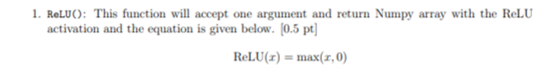

In [62]:
def ReLU(x):
  return np.maximum(x,0)

###softmax()

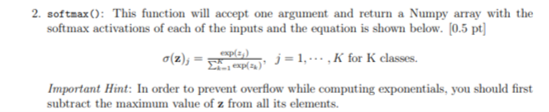

In [91]:
def softmax(x):
  exp_x = np.exp(x)
  exp_sum = np.sum(exp_x,axis=1,keepdims=True)
  return exp_x/exp_sum
##Note: subtract max value of z from all of its elements to avoid
#overflow

###compute() (implemented as computeLayer())

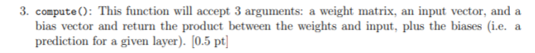

In [108]:
def computeLayer(X, W, b):
  mult = np.matmul(X.T, W) ###
  return mult+b

###averageCE()(implemented as CE())

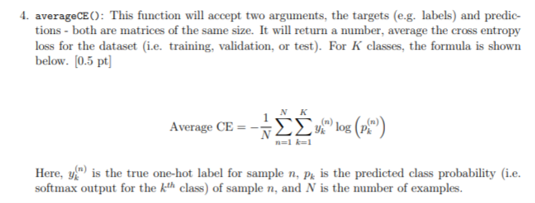

In [109]:
def CE(target, prediction):
  ce_out = -np.mean(target*np.log(prediction))
  return ce_out
##Note: Use softmax to feed in prediction P

###gradCE()

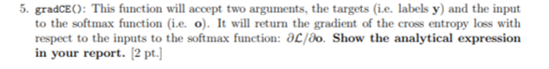

Analytical expression for gradient of CE

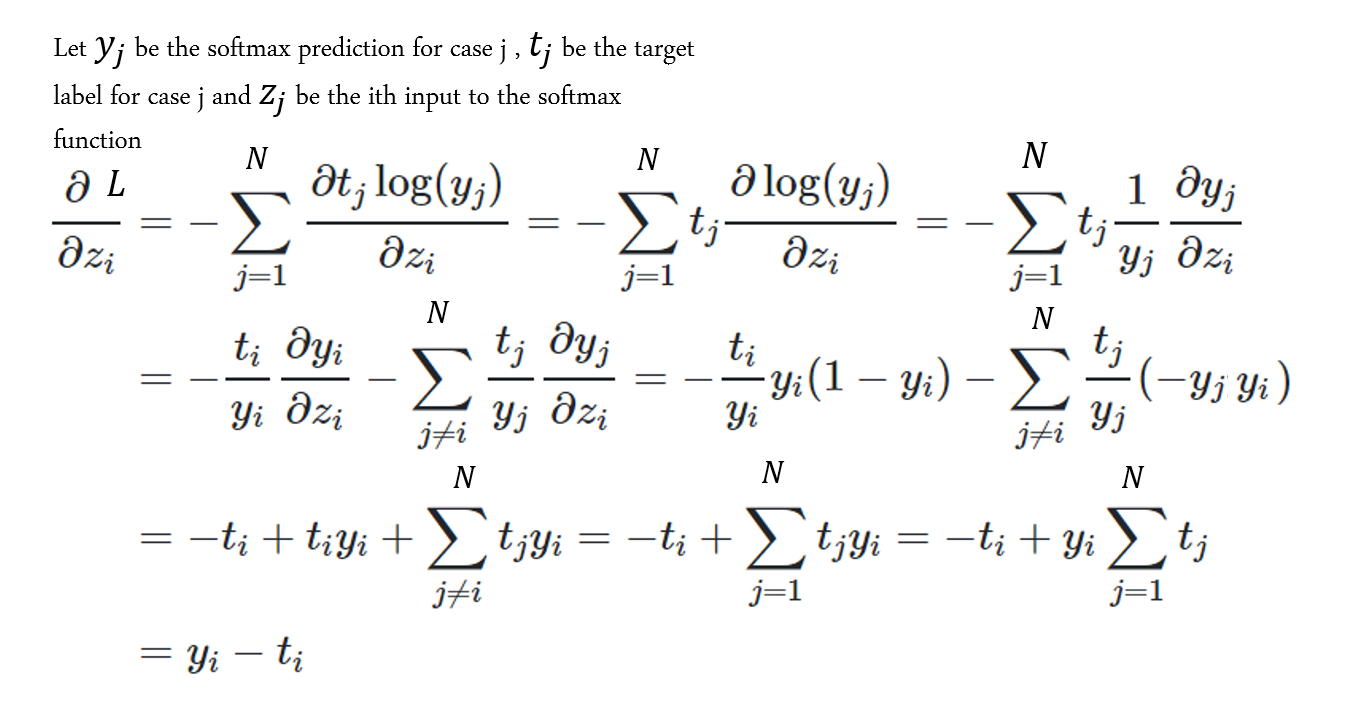

In [110]:
def gradCE(target, prediction):
  gradce_out = prediction - target
  return gradce_out
##Note: Use softmax to feed in prediction P

##Backpropagation Derivation


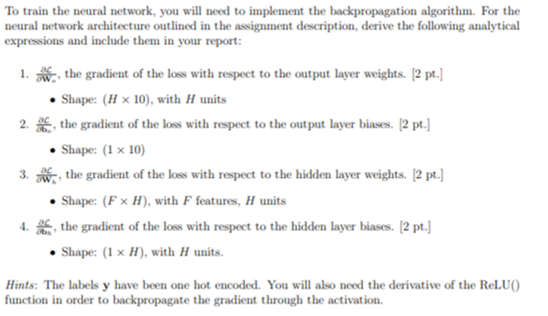

Analytical expresssions for the above partials:

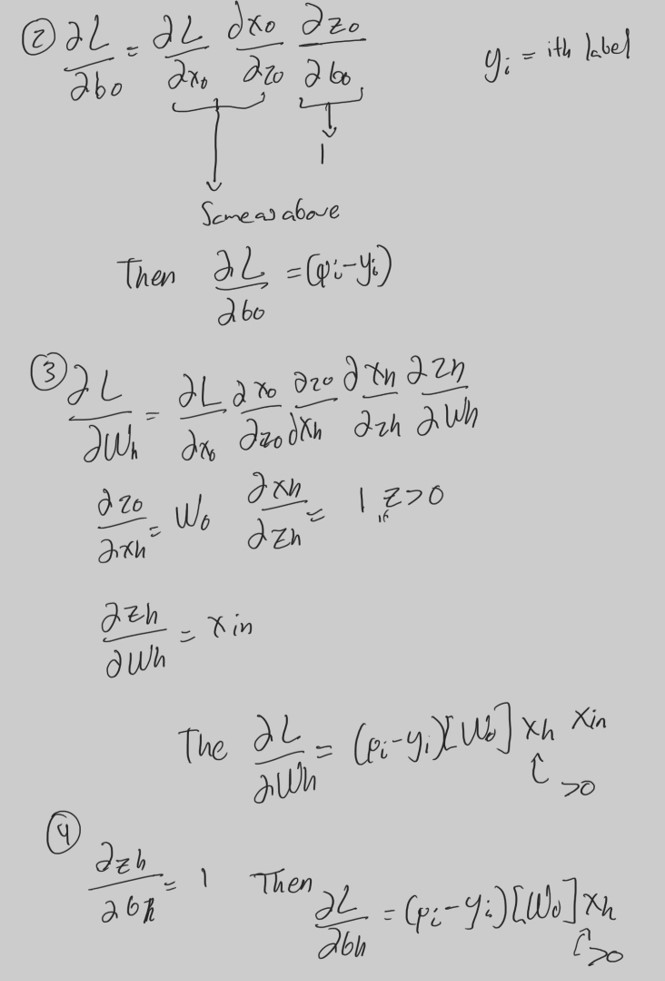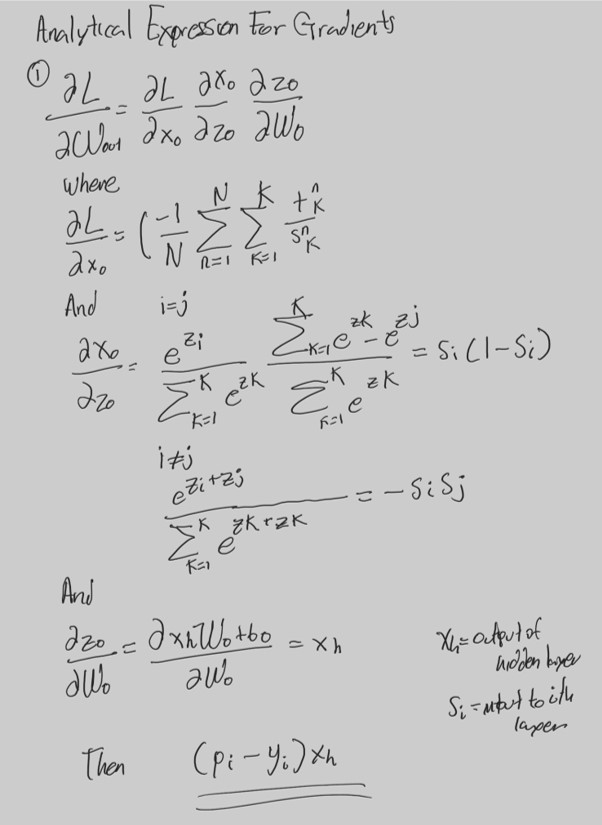

In [178]:
##Note: Use softmax to feed in prediction P
#Assuming no missing inputs to the function 
def b_W_out (target, prediction, hidden_out):
  gCE = gradCE(target,prediction) 
  g_W_out = np.matmul(hidden_out.T,gCE)
  return g_W_out

def b_b_out (target, prediction):
  gCE = gradCE(target,prediction)
  ones_M = np.ones((1, target.shape[0]))
  g_b_out = np.matmul(ones_M, gCE)
  return g_b_out

def b_W_hidden (target, prediction, input, input_out, output_weight):
  input_out[input_out > 0] = 1
  input_out[input_out < 0] = 0
  gCE = gradCE(target,prediction)
  g_W_hidden = np.matmul(input.T,(input_out * np.matmul(gCE, output_weight.T)))
  return g_W_hidden

def b_b_hidden (target, prediction,input_out, output_weight):
  input_out[input_out > 0] = 1
  input_out[input_out < 0] = 0
  ones_M = np.ones((1, input_out.shape[0]))
  gCE = gradCE(target,prediction)
  g_b_hidden = np.matmul(ones_M, (input_out * np.matmul(gCE, output_weight.T)))
  return g_b_hidden 


##Learning

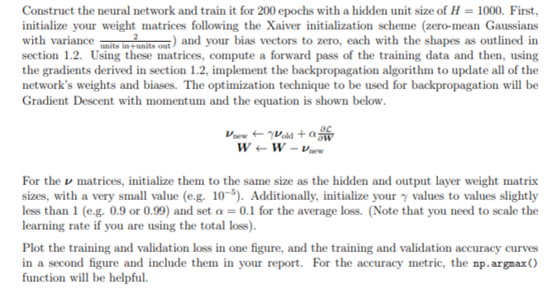

In [140]:
def forward(target,data,Wh,bh,Wo,bo,train_q): #if its training data, set to 1
  h_in = np.add(np.matmul(data, Wh), bh)
  h_out = ReLU(h_in)
  prediction = softmax(np.add(np.matmul(h_out, Wo), bo))
  loss = CE(target,prediction)
  prediction_M = np.argmax(prediction, axis = 1)
  target_M = np.argmax(target, axis = 1)
  comparison = np.equal(prediction_M, target_M)
  acc = np.sum((comparison==True))/(data.shape[0])
  if train_q == 1:
    return h_in,h_out,prediction,loss, acc
  elif train_q == 0:
    return loss, acc


In [176]:
def learning(trainData, target, Wo, vo, Wh, vh, num_epochs, gamma, lr, bo, bh, validData, newvalid, testData, newtest):
    Wvo = vo
    bvo = bo
    Wvh = vh
    bvh = bh
    train_acc,valid_acc,train_loss,valid_loss  = [],[],[],[]
    test_acc,test_loss = 0.0,0.0
    for i in range(num_epochs):

        h_in,h_out ,prediction,loss_tr, acc_tr = forward(newtrain,trainData,Wh,bh,Wo,bo,1)
        train_acc.append(acc_tr)
        train_loss.append(loss_tr)

        loss_vl, acc_vl = forward(newvalid,validData,Wh,bh,Wo,bo,0)
        valid_acc.append(acc_vl)
        valid_loss.append(loss_vl)
        
        Wvo = gamma*Wvo + lr*b_W_out(target, prediction, h_out)
        Wo = Wo - Wvo
        bvo = gamma*bvo + lr*b_b_out(target, prediction)
        bo = bo - bvo
        Wvh = gamma*Wvh + lr*b_W_hidden(target,prediction, trainData, h_in, Wo)
        Wh = Wh - Wvh
        bvh = gamma*bvh + lr*b_b_hidden(target, prediction, h_in, Wo)
        bh = bh - bvh

        print("Epoch {} done".format(i+1))

    test_loss, test_acc = forward(newtest,testData,Wh,bh,Wo,bo,0)
   
    epochs_l = np.arange(1, num_epochs + 1)

    plt.title("Training Curve")
    plt.plot(epochs_l,train_loss, label="Train")
    plt.plot(epochs_l,valid_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs_l, train_acc, label="Train")
    plt.plot(epochs_l, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy {} Final Training Loss {}".format( train_acc[-1], train_loss[-1]))
    print("Final Validation Accuracy {} Final Validation Loss {}".format( valid_acc[-1], valid_loss[-1]))
    print("Final Test Accuracy {} Final Test Loss {}".format(test_acc,test_loss))
    return Wo, bo, Wh, bh, train_acc, valid_acc, test_acc,train_loss, valid_loss, test_loss

Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done
Epoch 10 done
Epoch 11 done
Epoch 12 done
Epoch 13 done
Epoch 14 done
Epoch 15 done
Epoch 16 done
Epoch 17 done
Epoch 18 done
Epoch 19 done
Epoch 20 done
Epoch 21 done
Epoch 22 done
Epoch 23 done
Epoch 24 done
Epoch 25 done
Epoch 26 done
Epoch 27 done
Epoch 28 done
Epoch 29 done
Epoch 30 done
Epoch 31 done
Epoch 32 done
Epoch 33 done
Epoch 34 done
Epoch 35 done
Epoch 36 done
Epoch 37 done
Epoch 38 done
Epoch 39 done
Epoch 40 done
Epoch 41 done
Epoch 42 done
Epoch 43 done
Epoch 44 done
Epoch 45 done
Epoch 46 done
Epoch 47 done
Epoch 48 done
Epoch 49 done
Epoch 50 done
Epoch 51 done
Epoch 52 done
Epoch 53 done
Epoch 54 done
Epoch 55 done
Epoch 56 done
Epoch 57 done
Epoch 58 done
Epoch 59 done
Epoch 60 done
Epoch 61 done
Epoch 62 done
Epoch 63 done
Epoch 64 done
Epoch 65 done
Epoch 66 done
Epoch 67 done
Epoch 68 done
Epoch 69 done
Epoch 70 done
Epoch 71 done
Epoch 72 done
E

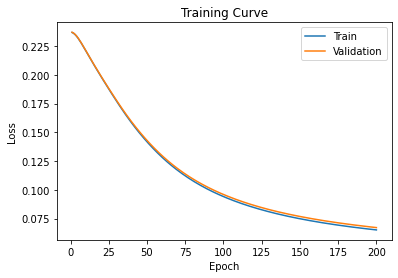

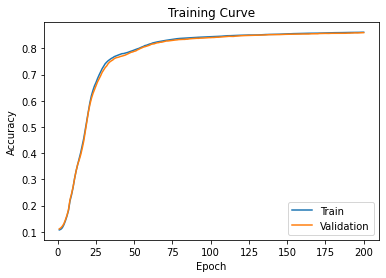

Final Training Accuracy 0.8619 Final Training Loss 0.06521361133375872
Final Validation Accuracy 0.8603333333333333 Final Validation Loss 0.06723878559489047
Final Test Accuracy 0.8711453744493393 Final Test Loss 0.06566064077522123


In [179]:
#num_epochs = 10
num_epochs = 200

#Data Loading
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainData = trainData.reshape((trainData.shape[0], -1))
validData = validData.reshape((validData.shape[0], -1))
testData = testData.reshape((testData.shape[0], -1))

#Target one hot encoding
newtrain, newvalid, newtest = convertOneHot(trainTarget, validTarget, testTarget)

#Xavier weight initialization


H = 1000
v_init_val = 1e-05
gamma = 0.9 #or 0.99
lr = 0.1 #alpha/learning rate

##Wx: Zero mean with var 2/(units_in + units_out)
##vx: Same size as the hidden and output layer weight matrix, values to 1e-05
##bx: initialized to 0

stddevo = 2.0/(H+10)
mean = 0
stddevh = 2.0/(trainData.shape[0]+H)

Wo = np.random.normal(mean, np.sqrt(stddevo), (H,10))
#Wo = np.zeros((H, 10))
vo = np.full((H, 10), v_init_val)
bo =  np.zeros((1, 10))
Wh = np.random.normal(mean, np.sqrt(stddevh), (trainData.shape[1],H))
#Wh = np.zeros((F, H))
vh = np.full((trainData.shape[1],H), v_init_val)
bh = np.zeros((1, H))

Wo_f,bo_f,Wh_f,bh_f, acc_train, acc_valid, acc_test,loss_train,loss_valid,loss_test \
 = learning(trainData, newtrain, Wo, vo, Wh, vh, num_epochs,gamma, learning_rate, bo, bh, validData, newvalid, testData, newtest)